In [7]:
# Imports
from astropy import units as u
import numpy as np
from math import pi

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit

from perylune.orbit_tools import *

In [8]:
# Create circular, equatorial orbit:
orb1 = Orbit.circular(Earth, 300 * u.km, 0*u.deg)
orb2 = Orbit.circular(Earth, 300 * u.km, 60*u.deg)

# Calculate the delta-v cost of inclination change from 87 to 88.4 degrees
dv_inc = inc_change(orb1, orb2)
print("Inclination change from %s to %s requires delta-v %s" % (orb1.inc, orb2.inc, dv_inc))

Inclination change from 0.0 deg to 60.0 deg requires delta-v 7.725760463451862 km / s


In [9]:
# Now calculate the cost for 60 deg change for eccentric orbits (500km)
alt = 500*u.km
ecc = 0.05*u.one
orb3 = Orbit.from_classical(Earth, Earth.R + alt, ecc, 0.0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg)
orb4 = Orbit.from_classical(Earth, Earth.R + alt, ecc, 60.0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg)
orb3_orig = orb3
print_orb(orb3)

6534 x 7222 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
a(𝑎)=6878.14km, b=6869.53km, e=0.05, i=0.00deg raan(Ω)=0.00deg argp(𝜔)=0.00deg nu(𝜈)=0.00deg
period=5676.98s perapis=6534km(156.09km) apoapsis=7222km(843.91km)


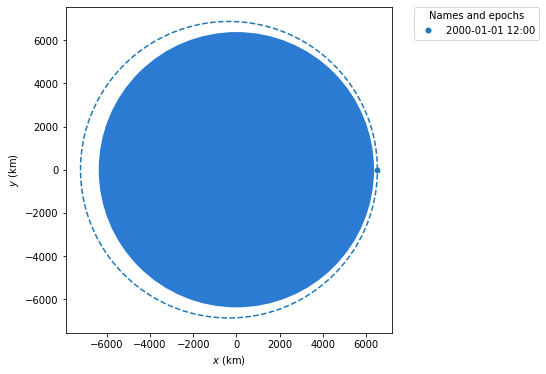

In [10]:
orb3.plot()

In [11]:
# Calculate velocity vector magnitudes for 200 samples spaced evenly around the full orbital period
samples = 200
delta_t = orb3.period / (samples - 1)
vel = calc_vel_inc_cost(orb3, orb4, delta_t, samples)

In [12]:
# We may now calculate some additional parameters.
#for v, t, nu, argp, dv, r in vel:
    #nu2pi = nu + 2*pi*u.rad*(nu<0) # nu normalized to 0..2pi
    # time_to_periapis = argp - nu2pi
    # print("v=%4.2f %s at %s, nu=%s time to argp=%s, delta-v cost=%s" % (v.value, v.unit, t.iso, nu, (time_to_periapis), abs(dv)))

In [13]:
# Generate chart for the whole orbit (nu = -pi..pi)

import plotly.express as px
import plotly.graph_objs as go
import numpy as np

# y - blue - orbital velocity [km/s]
# y2 - red - delta-v cost for inclination change [km/s]

# Note the lowest cost is when the object passes lines of apides (i.e. in the middle between apoapsis and periapsis)

nu_tbl = []
v_tbl = []
dv_tbl = []
r_tbl = []
for v,t,nu,argp, dv, r in vel:
    nu_tbl.append(nu.value)
    v_tbl.append(v.value)
    dv_tbl.append(dv.value)
    r_tbl.append(r.value)


fig = go.Figure()
fig.add_trace(go.Scatter(x = nu_tbl, y = dv_tbl, mode="markers", name="Delta-v [km/s]"))
fig.add_trace(go.Scatter(x = nu_tbl, y = v_tbl, mode="markers", name="Orbital velocity [km/s]"))


#fig.add_trace(go.Scatter(x = nu_tbl, y = r_tbl, mode="markers", name="distance [km]"))

# Update legend to show at the top
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), 
                  xaxis_title="True anomaly 𝜈 [rad]", yaxis_title="Veloicty [km/s]", title="Orbit alt=500km ecc=0.05 (843x156km)",
                  margin=dict(l=20, r=20, t=20, b=20))

fig.add_annotation(x=0, y=7.24, text="periapsis")
fig.add_annotation(x=pi, y=7.24, text="apoapsis")

fig.show()


In [14]:
# Perform inclination change. The inclination change can be done at the nodes (ascending or descending) only. (TODO: why?)
# First we need to propagate the orbit to the AN
orb5 = propagate_to_asc_node(orb4)

print_orb(orb4)
print_orb(orb5)

Propagating to AN: 0.0 deg
6534 x 7222 km x 60.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
a(𝑎)=6878.14km, b=6869.53km, e=0.05, i=60.00deg raan(Ω)=0.00deg argp(𝜔)=0.00deg nu(𝜈)=0.00deg
period=5676.98s perapis=6534km(156.09km) apoapsis=7222km(843.91km)
6534 x 7222 km x 60.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
a(𝑎)=6878.14km, b=6869.53km, e=0.05, i=60.00deg raan(Ω)=0.00deg argp(𝜔)=0.00deg nu(𝜈)=0.00deg
period=5676.98s perapis=6534km(156.09km) apoapsis=7222km(843.91km)
